# Calculation of Regression Model and Weighting

This notebook is used to determine regression models and weightings of a calibration. Three replicas of calibrations and quality controls are required to run this notebook. This notebook uses an Excel table. 
The first sheet "Area" contains the peak areas of the analytes and the internal standards (marked by "IS_"). The first column contains the "Replicate" ("Calibration_1") followed by the second column "Calibrator" which contains the levels of the calibrators (Cal_1 to Cal_5 and QC_LLOQ, QC_Low, QC_Th, and QC_High). The third column starts with the first analyte.
The second sheet "Concentration" contains the respective target concentrations of the calibrators or quality controls. The structure corresponds to that of sheet "Area" with the difference that the concentrations of the analytes are included instead of the peak areas

In [32]:
## Load libraries and functions
library(tidyverse)
library(readxl)
library(writexl)
library(readr)
library(stringr)
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 200, scipen = -1)

eval_is <- function(data, names){
    
    qc <- data[str_detect(names, "QC")]
    qc_names <- str_sub(names[str_detect(names, "QC")][order(qc)], 4, -1)
          
    cal <- data[str_detect(names, "Cal")]
    cal_names <- str_sub(names[str_detect(names, "Cal")][order(cal)], 5, -1)
    
    candidates_qc <- rep(NA, length(qc_names))
    candidates_cal <- rep(NA, length(cal_names))
    
    for (i in 1:length(qc_names)) {
        
        candidates_qc[i] <- qc_names[i]
        candidates_cal[i] <- cal_names[i]
        
        if(candidates_qc[i] %in% candidates_cal | candidates_cal[i] %in% candidates_qc) {
            
            return(candidates_qc[i])
            break
            
        }
        
    }
    
    
}

eval_weights <- function(data) {
    
    subset <- data[,c(-1)]
    weights <- rep(NA,nrow(subset)) 
    
    for(i in 1:nrow(subset)) {
                
        minrss <- which(subset[i,] == min(subset[i,]))
        
        weights[i] <- ifelse(data$F_Test_Heteroscedasticity[i] < 0.05, 
                             colnames(subset)[minrss], "none")
        
    }
    
    return(weights)
    
}

In [33]:
## Import data sheets
areas <- read_excel("Calibration.xlsx", sheet = "Areas") %>%
         select(!contains("PRM")) %>%
         as.data.frame()

conc <- read_excel("Calibration.xlsx", sheet = "Concentrations") %>%
        select(!contains("PRM")) %>%
        as.data.frame()

## Split analytes in calibration and quality control samples
areas_analytes <- select(areas, !contains("IS_"))
areas_analytes_cal <- filter(areas_analytes, grepl("Cal", Calibrator))
areas_analytes_qc <- filter(areas_analytes, grepl("QC", Calibrator))

## Split internal standards in calibration and quality control samples
areas_is <- select(areas, Replicate, Calibrator, contains("IS_"))
areas_is_cal <- filter(areas_is, grepl("Cal", Calibrator))
areas_is_qc <- filter(areas_is, grepl("QC", Calibrator))

## Split calibration concentrations in calibration and quality control samples
conc_cal <- filter(conc, grepl("Cal", Calibrator))
conc_qc <- filter(conc, grepl("QC", Calibrator))

## Determine grid dimensions for plots
grid_row_anal <- ceiling(sqrt(ncol(areas_analytes)-2))
grid_col_anal <- ceiling(sqrt(ncol(areas_analytes)-2))
grid_row_is <- ceiling(sqrt(ncol(areas_analytes)-2 + ncol(areas_is)-2))
grid_col_is <- ceiling(sqrt(ncol(areas_analytes)-2 + ncol(areas_is)-2))

## Determine names of internal standards
nIS <- colnames(areas_is)[-(1:2)]

In [31]:
## Initialise results tables
results_long <- matrix(ncol = 7 + 2 * length(nIS), 
                       nrow = length(colnames(areas_analytes))-2, byrow = TRUE,
                       dimnames = list(colnames(areas_analytes)[-(1:2)],
                                       c("Mandel_Test", paste0("QC_", nIS),
                                         paste0("Cal_", nIS),
                                         "F_Test_Heteroscedasticity" , "No_Weighting", 
                                         "1_x", "1_x_2", "1_y", "1_y_2"))) %>%
                as.data.frame()

results_short <- matrix(ncol = 3, nrow = length(colnames(areas_analytes))-2, byrow = TRUE,
                 dimnames = list(colnames(areas_analytes)[-(1:2)],
                                 c("Regression_Model", "IS", "Weighting_Method"))) %>%
                 as.data.frame()

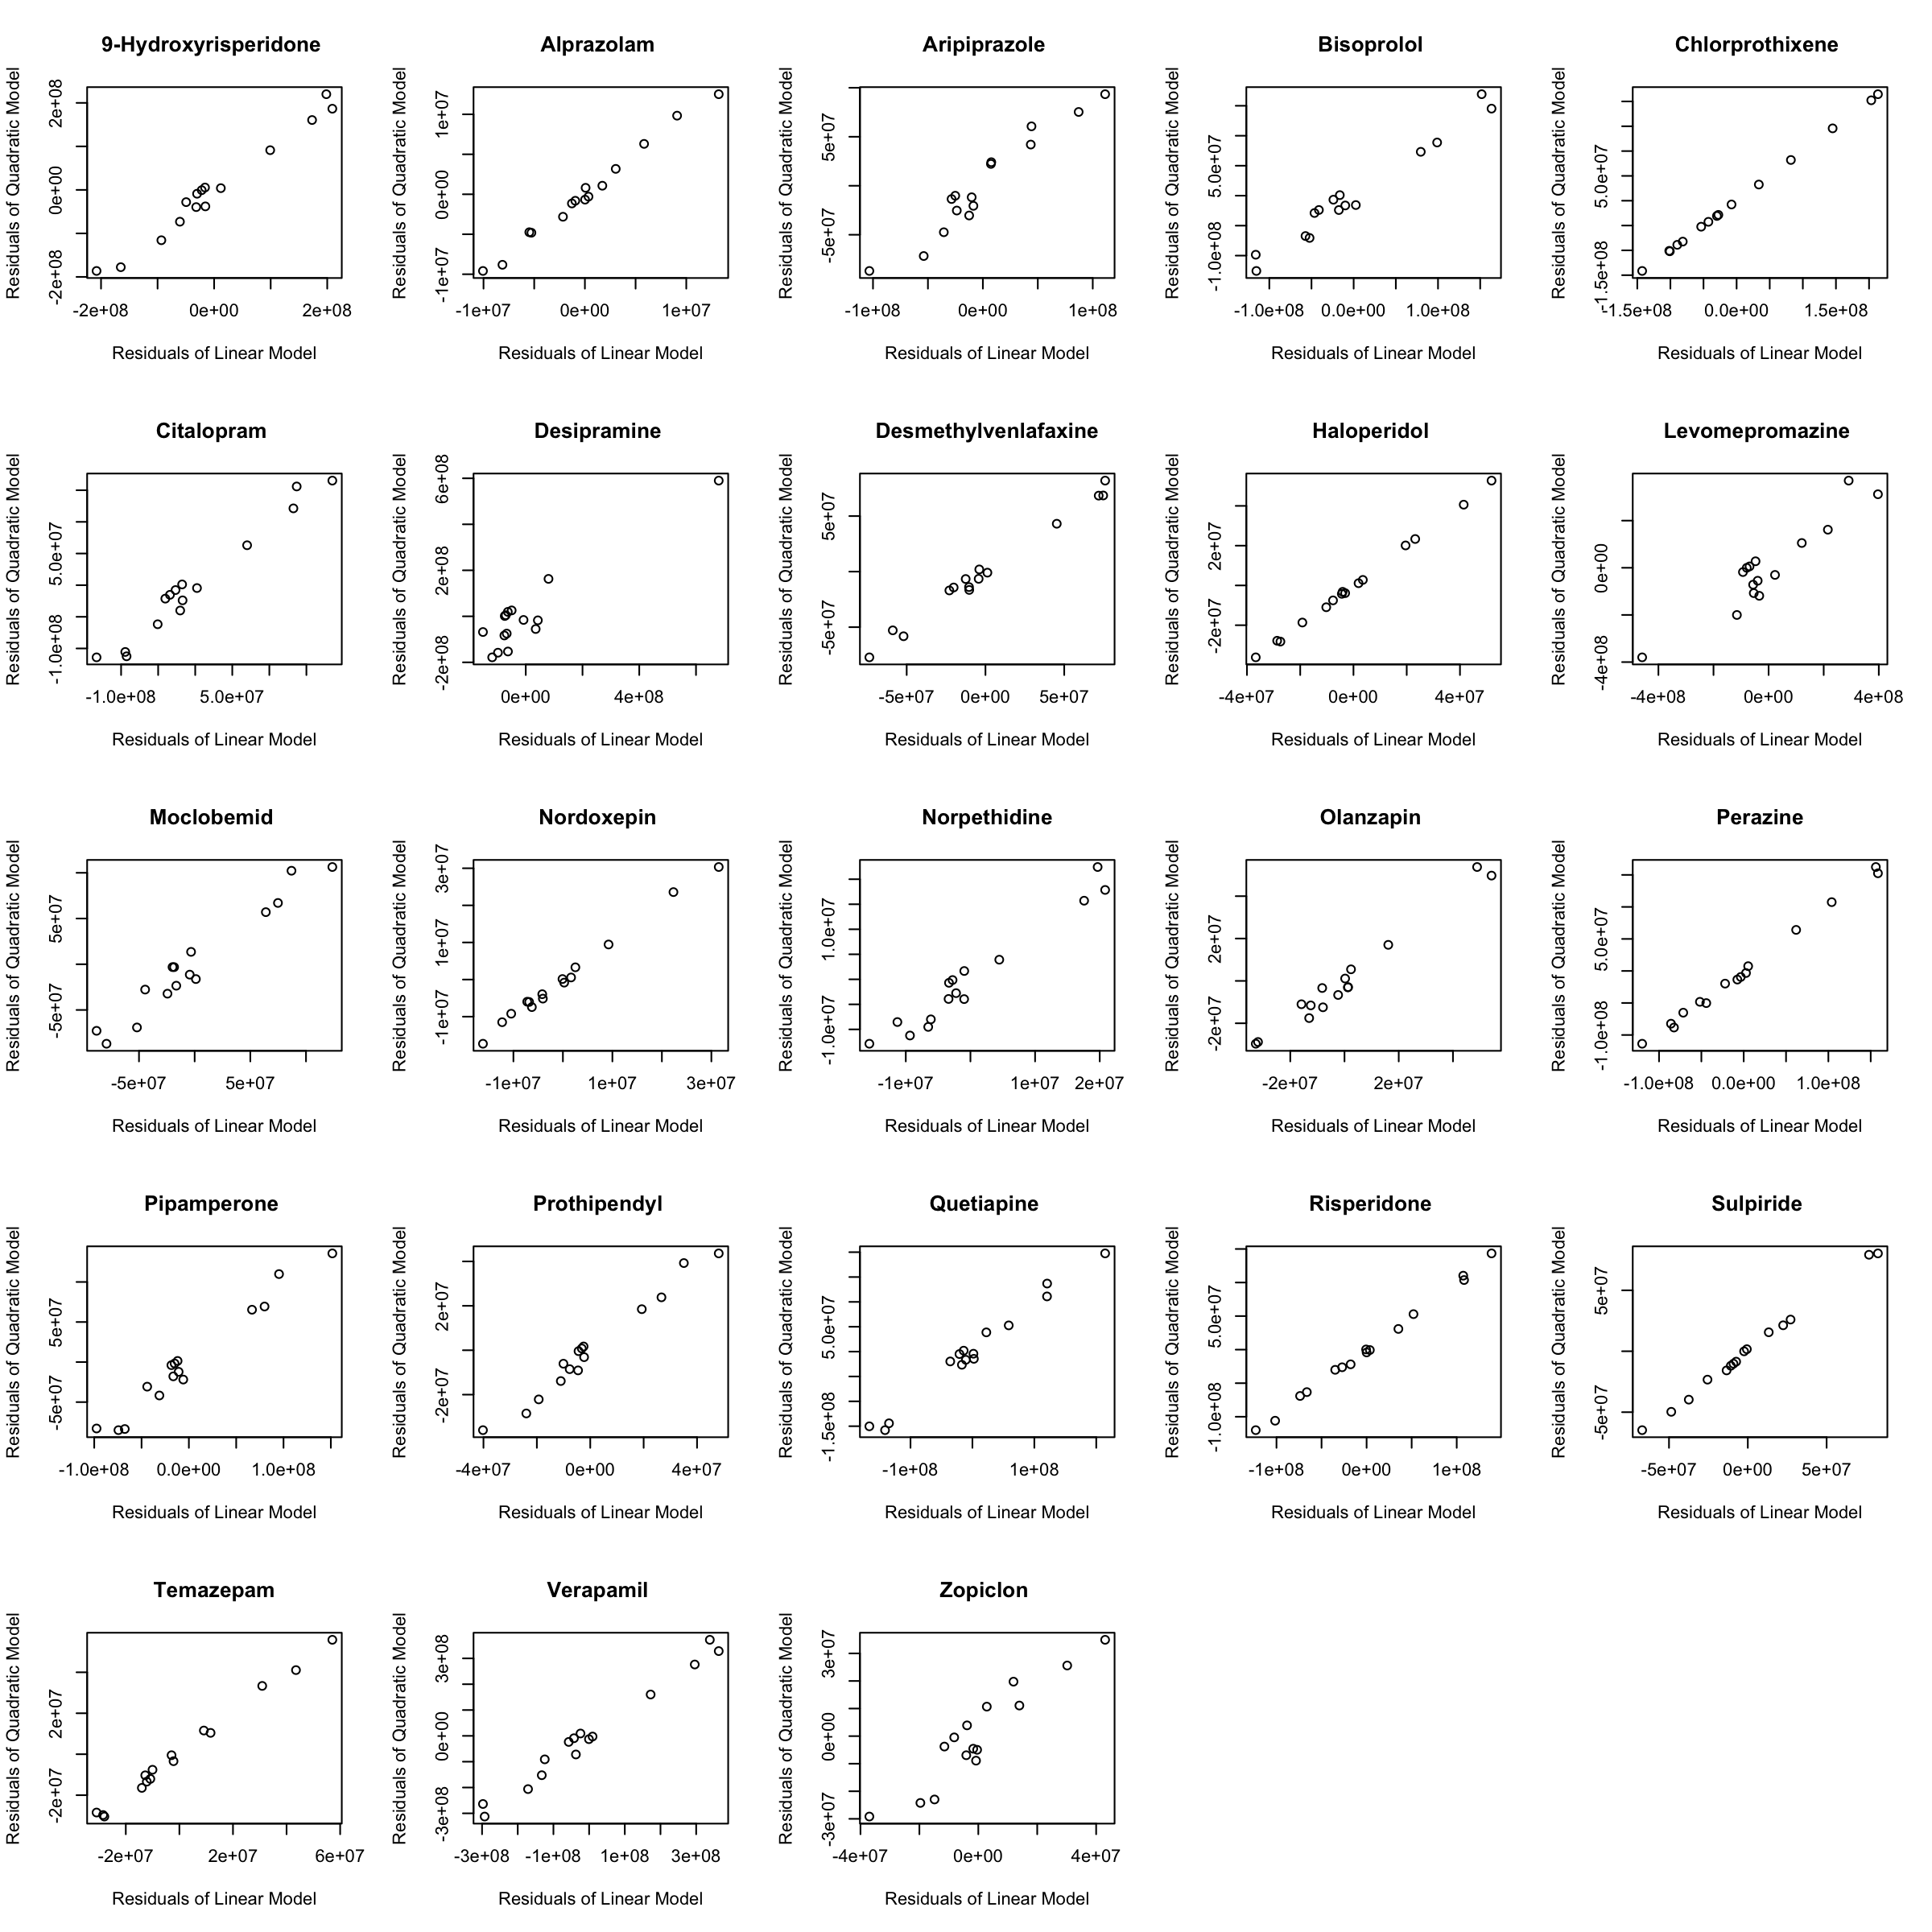

In [34]:
par(mfrow = c(grid_row_anal, grid_col_anal))

## Evaluate regression model
for (i in 3:ncol(areas_analytes_cal)) {
 
    ## Prepare matrix for regression
    matrix <- as.data.frame(cbind(areas_analytes_cal[,i], conc_cal[,i]))
    colnames(matrix) <- c("Area", "Concentration")
    
    ## Perform linear and quadratic regression and plot both models
    linear_model <- lm(Area~Concentration, data = matrix)
    quadratic_model <- lm(Area~poly(Concentration,2), data = matrix)
    
    ## Anwenden der Modelle auf Daten
    matrix$Area_pred_lin <- predict(linear_model, newdata = matrix)
    matrix$Area_pred_quad <- predict(quadratic_model, newdata = matrix)

    ## Plot residuals of both models
    plot(linear_model$residuals, quadratic_model$residuals, 
         main = colnames(areas_analytes_cal)[i],
         xlab = "Residuals of Linear Model",
         ylab = "Residuals of Quadratic Model")
    
    
    ## Perform F-Test of residuals and return p-value
    f_test <- var.test(linear_model$residuals, quadratic_model$residual)
    results_long$Mandel_Test[i-2] <- f_test$p.value
    
    
}

## Evaluate long results for short results
results_short$Regression_Model <- ifelse(results_long$Mandel_Test < 0.05, "Quadratic", "Linear")

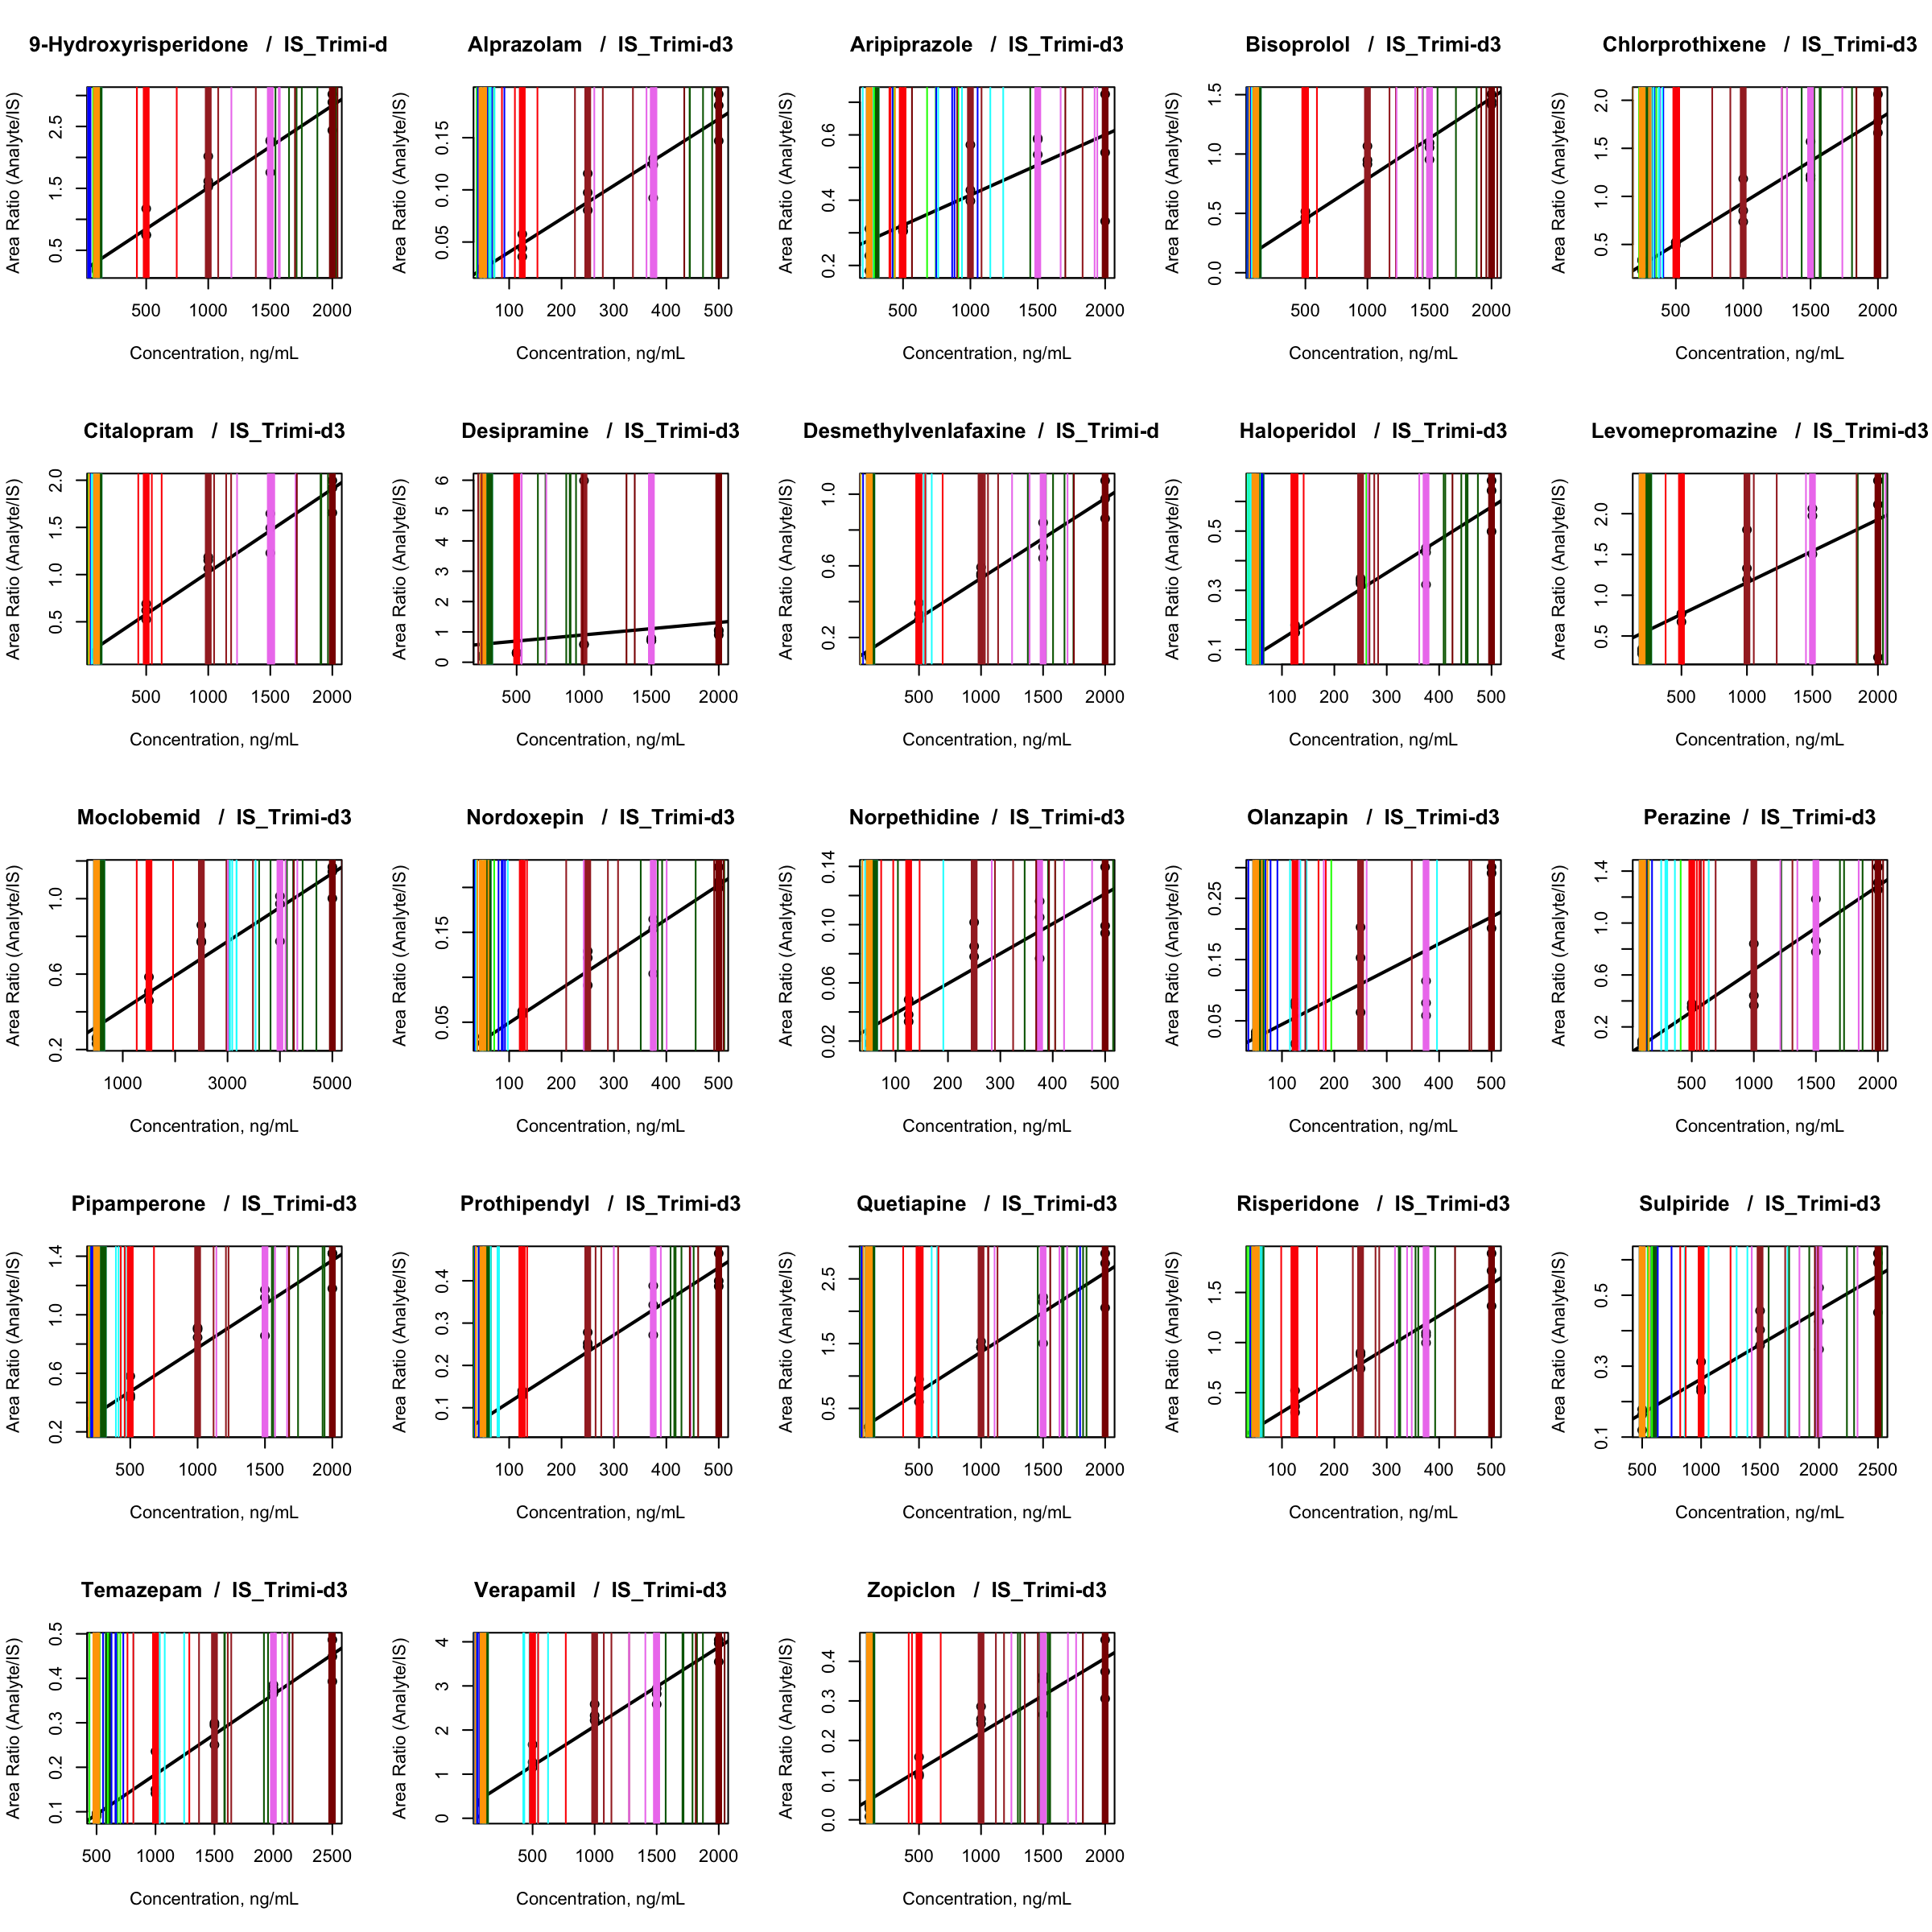

In [35]:
par(mfrow = c(grid_row_is, grid_col_is))

## Evaluate internal standards in regards of QC deviation
for (i in 3:ncol(areas_analytes_cal)) {
    
    for (j in 3:ncol(areas_is_cal)) {

        ## Calculate area ratios of the calibration with internal standards
        areas_norm <- data.frame(areaRatio = areas_analytes_cal[,i] / areas_is_cal[,j])
        matrix <- data.frame(areaRatio = areas_norm, Concentration = conc_cal[,i])

        ## Perform linear regression and predict QC concentration
        linear_model <- lm(areaRatio~Concentration, data = matrix)
        model_summary <- summary(linear_model)
        
        ## Calculate QC concentration and deviation from spiked concentration
        qc_areaRatio <- data.frame(areaRatio = (areas_analytes_qc[,i] / areas_is_qc[,j]))
        qc_spiked <- data.frame(Concentration = conc_qc[,i])
        qc_calc <- (qc_areaRatio - model_summary$coefficients[1,1]) / model_summary$coefficients[2,1]
        qc_dev <- (qc_calc - qc_spiked) / qc_spiked * 100
        
        ## Calculate calibrator concentration and deviation from spiked concentration
        cal_calc <- (matrix$areaRatio - model_summary$coefficients[1,1]) / model_summary$coefficients[2,1]
        cal_dev <- (cal_calc - matrix$Concentration) / matrix$Concentration * 100

        ## Plot QC deviation
        plot(matrix$Concentration, matrix$areaRatio, 
             main = paste(colnames(areas_analytes_cal)[i] , " / " ,colnames(areas_is_cal)[j]),
             xlab = "Concentration, ng/mL",
             ylab = "Area Ratio (Analyte/IS)", pch = 1)
        abline(linear_model, col = "black", lwd = 2)
        abline(v = qc_spiked$Concentration[1], lwd = 4, col = "green")
        abline(v = qc_spiked$Concentration[2], lwd = 4, col = "blue")
        abline(v = qc_spiked$Concentration[3], lwd = 4, col = "cyan")
        abline(v = qc_spiked$Concentration[4], lwd = 4, col = "darkgreen")
        abline(v = qc_calc[conc_qc$Calibrator == "QC_LLOQ",1], col = "green")
        abline(v = qc_calc[conc_qc$Calibrator == "QC_LOW",1], col = "blue")
        abline(v = qc_calc[conc_qc$Calibrator == "QC_TH",1], col = "cyan")
        abline(v = qc_calc[conc_qc$Calibrator == "QC_HIGH",1], col = "darkgreen")
        abline(v = matrix$Concentration[1], lwd = 4, col = "orange")
        abline(v = matrix$Concentration[2], lwd = 4, col = "red")
        abline(v = matrix$Concentration[3], lwd = 4, col = "brown")
        abline(v = matrix$Concentration[4], lwd = 4, col = "violet")
        abline(v = matrix$Concentration[5], lwd = 4, col = "darkred")
        abline(v = cal_calc[conc_cal$Calibrator == "Cal_1"], col = "orange")
        abline(v = cal_calc[conc_cal$Calibrator == "Cal_2"], col = "red")
        abline(v = cal_calc[conc_cal$Calibrator == "Cal_3"], col = "brown")
        abline(v = cal_calc[conc_cal$Calibrator == "Cal_4"], col = "violet")
        abline(v = cal_calc[conc_cal$Calibrator == "Cal_5"], col = "darkred")
        #legend(x = "bottomright", legend = c("Regression", "Cal 1", "Cal 2", "Cal 3","Cal 4", "Cal 5", 
        #"QC_LLOQ", "QC_Low", "QC_Th", "QC_High"), 
        #       lty = c(1, 1, 1, 1, 1, 1),col = c("black", "orange", "red", "brown", "green", "blue"))

        ## Evaluate median  of absolute QC deviation
        results_long[i-2,j-1] <- mean(abs(qc_dev[,1]))
        results_long[i-2,j-1+length(nIS)] <- mean(abs(cal_dev))
    
    }
    
}

## Evaluate long results for short results
results_short$IS <- apply(results_long, 1, eval_is, names = colnames(results_long))

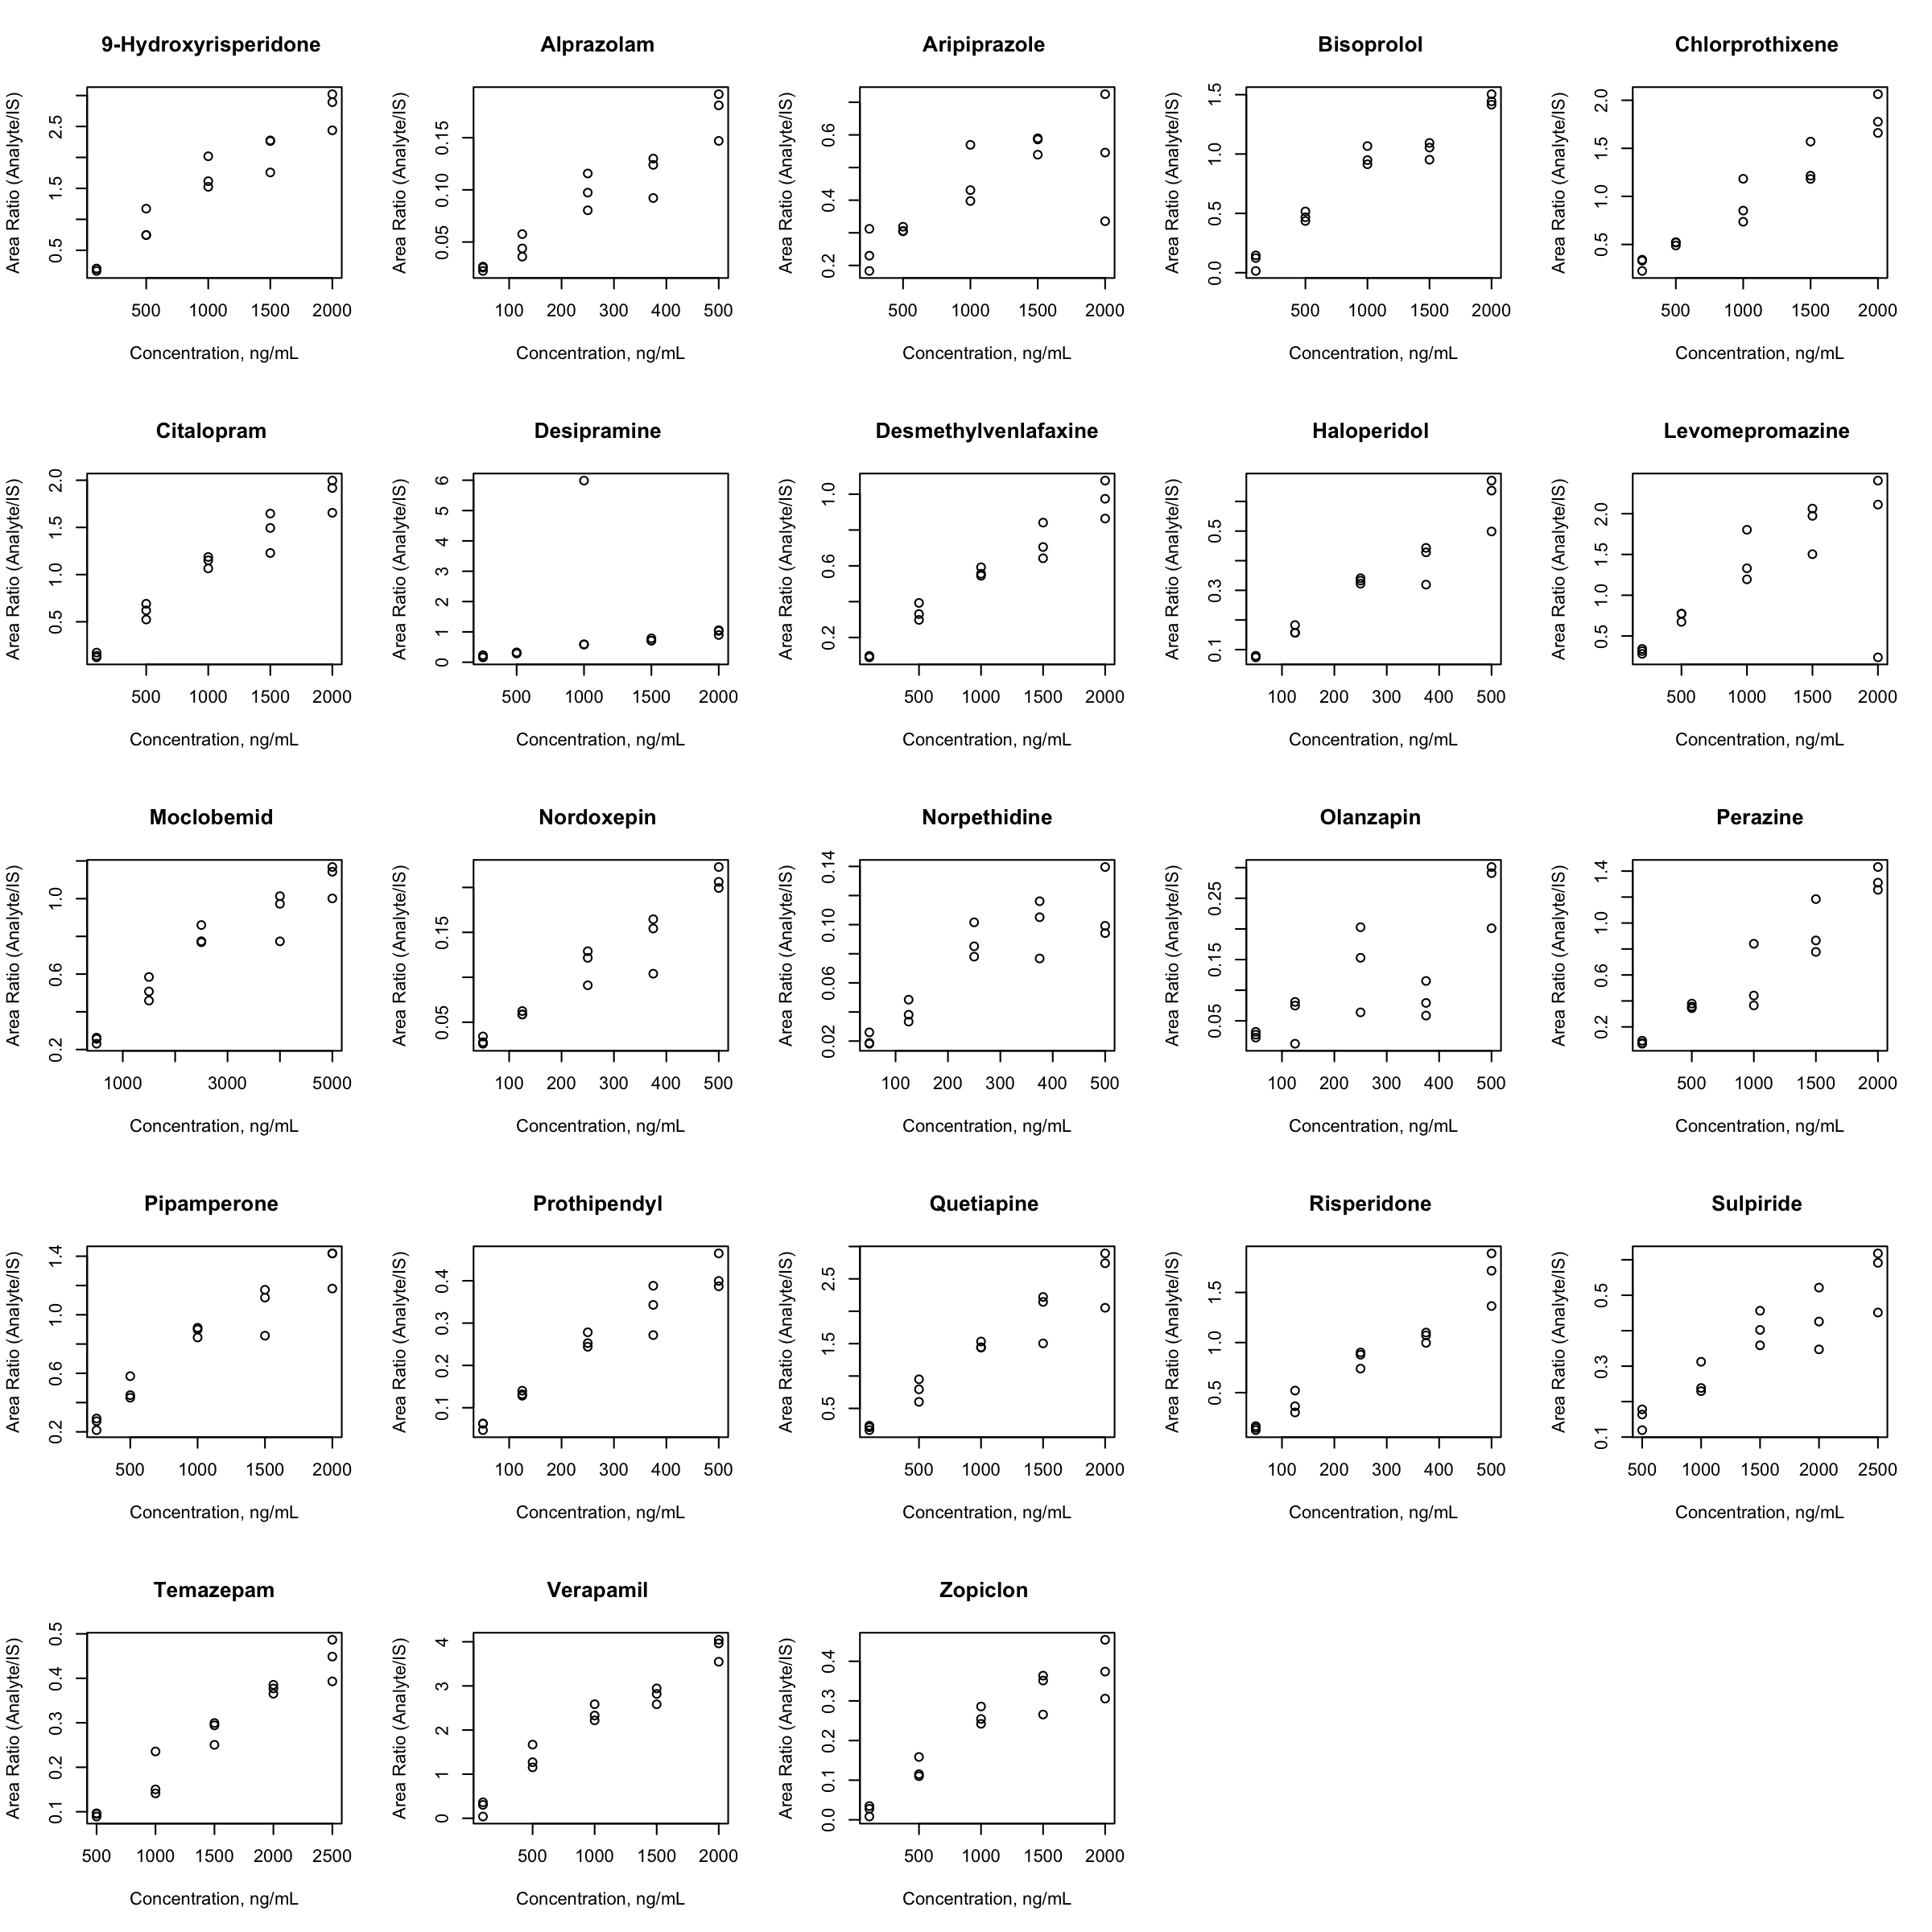

In [36]:
par(mfrow = c(grid_row_anal, grid_col_anal))

for (i in 3:ncol(areas_analytes_cal)) {
    
    areas_norm <- data.frame(areaRatio = areas_analytes_cal[,i] / 
                             areas_is_cal[,which(colnames(areas_is_cal) == results_short$IS[i-2])])
    matrix <- cbind(areas_norm, conc_cal[,i])
    colnames(matrix) <- c("areaRatio", "Concentration")
    
    plot(matrix$Concentration, matrix$areaRatio, main = colnames(areas_analytes_cal)[i],
        ylab = "Area Ratio (Analyte/IS)", xlab = "Concentration, ng/mL")

    results_long$F_Test_Heteroscedasticity[i-2] <- var.test(matrix$areaRatio[areas_analytes_cal$Calibrator == "Kal_1"], 
                                                       matrix$areaRatio[areas_analytes_cal$Calibrator == "Kal_5"], 
                                                       alternative = "two.sided")$p.value
    
}

In [37]:
for (i in 3:ncol(areas_analytes_cal)) {
    
    ## Calculate area ratios of the calibration with internal standards
    areas_norm <- data.frame(areaRatio = areas_analytes_cal[,i] / 
                             areas_is_cal[,which(colnames(areas_is_cal) == results_short$IS[i-2])])
    matrix <- data.frame(areaRatio = areas_norm, Concentration = conc_cal[,i])

    ## Perform linear regression with several weightings and calculate residual sum of squares
    w0 <- lm(areaRatio~Concentration, data = matrix)
    results_long$No_Weighting[i-2] <- deviance(w0)
    
    
    weights1 <- 1/matrix$Concentration
    w1 <- lm(areaRatio~Concentration, data = matrix, weights = weights1)
    results_long$"1_x"[i-2] <- deviance(w1)
    
    weights2 <- 1/matrix$Concentration^2
    w2 <- lm(areaRatio~Concentration, data = matrix, weights = weights2)
    results_long$"1_x_2"[i-2] <- deviance(w2)
    
    weights3 <- 1/matrix$areaRatio
    w3 <- lm(areaRatio~Concentration, data = matrix, weights = weights3)
    results_long$"1_y"[i-2] <- deviance(w3)
    
    weights4 <- 1/matrix$areaRatio^2
    w4 <- lm(areaRatio~Concentration, data = matrix, weights = weights4)
    results_long$"1_y_2"[i-2] <- deviance(w4)
    
}

results_short$Weighting_Method <- results_long[,((ncol(results_long)-5):ncol(results_long))] %>%
                                  eval_weights()

In [38]:
results_long
results_short

write_xlsx(list(Results_Short = results_short %>%
                rownames_to_column("Analyte"),
                Results_Long = results_long %>%
                rownames_to_column("Analyte")),
           "Results.xlsx")

,Mandel_Test,QC_IS_Trimi-d3,Cal_IS_Trimi-d3,F_Test_Heteroscedasticity,No_Weighting,1_x,1_x_2,1_y,1_y_2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9-Hydroxyrisperidone,0.9653617,74.38353,30.848297,0.009450668,8.325341e-01,8.823960e-04,1.137624e-06,0.50591421,0.3341906
Alprazolam,0.9861957,22.21178,14.993132,0.017003462,3.651315e-03,1.169761e-05,4.876893e-08,0.03483841,0.3948157
Aripiprazole,0.8945419,127.18379,47.720069,0.202178577,1.395315e-01,1.178407e-04,1.926756e-07,0.34646749,0.8864934
Bisoprolol,0.9532934,45.32729,35.180317,0.583858863,1.960118e-01,3.087529e-04,1.192643e-06,0.49449735,1.9945841
Chlorprothixene,0.9999027,12.68973,14.267720,0.177484800,3.057474e-01,2.539242e-04,3.109788e-07,0.26211216,0.3110577
Citalopram,0.9513566,39.86325,27.404339,0.040274438,2.441675e-01,2.394259e-04,3.612323e-07,0.23061472,0.2664744
Desipramine,0.7937328,234.97922,230.773174,0.338868020,2.774163e+01,2.784546e-02,2.728575e-05,4.98792194,0.9513902
Desmethylvenlafaxine,0.9823725,51.62816,25.647153,0.002877633,6.142121e-02,6.052006e-05,7.461902e-08,0.10481749,0.1985481
Haloperidol,0.9988940,28.98385,9.997084,0.001974222,3.626012e-02,9.155364e-05,2.610533e-07,0.08778992,0.2349321


,Regression_Model,IS,Weighting_Method
,<chr>,<chr>,<chr>
9-Hydroxyrisperidone,Linear,IS_Trimi-d3,1_x_2
Alprazolam,Linear,IS_Trimi-d3,1_x_2
Aripiprazole,Linear,IS_Trimi-d3,none
Bisoprolol,Linear,IS_Trimi-d3,none
Chlorprothixene,Linear,IS_Trimi-d3,none
Citalopram,Linear,IS_Trimi-d3,1_x_2
Desipramine,Linear,IS_Trimi-d3,none
Desmethylvenlafaxine,Linear,IS_Trimi-d3,1_x_2
Haloperidol,Linear,IS_Trimi-d3,1_x_2


In [39]:
sessionInfo()

R version 4.0.1 (2020-06-06)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS  10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] de_DE.UTF-8/de_DE.UTF-8/de_DE.UTF-8/C/de_DE.UTF-8/de_DE.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] writexl_1.4.0   readxl_1.3.1    forcats_0.5.1   stringr_1.4.0  
 [5] dplyr_1.0.7     purrr_0.3.4     readr_2.0.2     tidyr_1.1.4    
 [9] tibble_3.1.5    ggplot2_3.3.5   tidyverse_1.3.1

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-5     tidyselect_1.1.1 repr_1.1.3       haven_2.4.3     
 [5] colorspace_2.0-2 vctrs_0.3.8      generics_0.1.0   htmltools_0.5.2 
 [9] base64enc_0.1-3  utf8_1.2.2       rlang_0.4.11     pillar_1.6.3    
[13] glue_1.4.2       withr_2.4.2      DBI_1.1.1      